# Proyecto Decision Trees

In [20]:
# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería para generar un modelo de Regresión Lineal: 
import statsmodels.api as sm

# Librería para realizar operaciones matemáticas: 
import numpy as np

# Librería para poder realizar la partición del conjunto de datos:
from sklearn.model_selection import train_test_split

# Librería para generar un modelo XGBoost:
import xgboost as xgb

# Librería para calcular el VIF: 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Librería para visualizar datos estadísticos: 
import seaborn as sns

# Librería para utilizar árboles de decisión clasificadores:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Librería para evaluar el rendimiento de los modelos de Machine Learning:
from sklearn.metrics import *

# Librería para medir la especificidad:
from imblearn.metrics import specificity_score

## Paso 1 - Lectura de Datos:

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/decision-tree-clara-ab/data/raw/diabetes.csv* y se ha cargado en un Data Frame:

In [21]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo:
df = pd.read_csv ('/workspaces/decision-tree-clara-ab/data/raw/diabetes.csv');

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Una vez se ha cargado correctamente la información en el Data Frame es interesante evaluar la **cantidad de información que se tiene**. Para ello, se recurre al atributo `.shape` del Data Frame:

In [22]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print (f" El conjunto de datos cuenta con información de {df.shape[0]} pacientes con total de {df.shape[1]} características sobre ellos");

 El conjunto de datos cuenta con información de 768 pacientes con total de 9 características sobre ellos


## Paso 2 - Análisis Exploratorio de Datos:

Antes de realizar un estudio del modelo tipo **Decision Trees** , es fundamental llevar a acabo un análisis de los datos **para poder identificar** patrones, detectar valores atípicos y evaluar la distribución de las variables para comprender la relación entre ellas.

Por este motivo, se van a realizar distintos pasos cuyo objetivo final es **preparar el conjunto de datos** para poder trabajar con ellos. Este EDA no se explicará tan en detalle como se hizo para el proyecto dedicado únicamente a ello pero se recomienda recurrir a él para explicaciones más detalladas:

### Paso 2.1 - Análisis de Constantes y Duplicados:

Uno de los puntos críticos a la hora de realizar un análisis, es la existencia de **variables / características comunes** a todos los pacientes, dado que sería **información redundante** y no aportaría valor al estudio, es decir, el análisis sería el mismo aunque no estuviesen como variables y, por lo tanto, se podría prescindir de ellas.

In [23]:
# Se utiliza el método .nunique() para saber la cantidad de columnas con constantes en el Data Frame:
print(f" Hay un total de {(lambda df: (df.nunique() == 1).sum())(df)} columnas en el Data Frame con un valor constante para todos los pacientes");

# Se imprime el conteo de valores distintos en cada columna:
print (f" \nPara cada columna del Data Frame, se muestran cuántos valores distintos presentan:");
df.nunique()

 Hay un total de 0 columnas en el Data Frame con un valor constante para todos los pacientes
 
Para cada columna del Data Frame, se muestran cuántos valores distintos presentan:


Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

A partir del resultado obtenido, se puede observar que **no hay ninguna constante** en los datos cargados, por lo tanto, no hay que eliminar ninguna columna, de momento.

Otro factor determinante a la hora de realizar una limpieza de los datos es detectar si hay **datos repetidos**, aplicado a este caso, si hay **pacientes duplicados**.

In [24]:
# Se utiliza el método .duplicated() para identificar los clientes repetidos dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} pacientes duplicados.");

 Hay un total de 0 pacientes duplicados.


Como se puede ver, **no se ha detectado un cliente duplicado** en el conjunto de datos por lo que se puede seguir con el análisis exploratorio de datos. 

## Paso 2.2 - Análisis Estadístico:

Una vez ya se ha realizado un estudio básico para realizar una primera limpieza de datos, a partir del análisis de constantes y duplicados, se puede pasar a **observar estadísticamente la información** y decidir qué datos son poco relevantes.

Para ello, en primer lugar, se va a recurrir al método `.describe()`  para tener un **resumen estadístico** de todos los datos, tanto los categóricos como los numéricos.

En este resumen, los puntos más interesantes son, por un lado, los **mínimos y los máximos** en las variables numéricas y el **top value y su frecuencia** para las variables categóricas.

In [25]:
# Descripción estadística básica de todas las columnas del DataFrame:
df.describe(include='all').T # Se traspone para ver de forma más clara los datos

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


En este caso, interesaba principalmente **desechar pacientes cuya información aportada no fuese** *lógica*, por ejemplo, alguien que presentase una edad exageradamente alta.

Sin embargo, no se ha encontrado ningún caso extremo, por lo que **no será necesario realizar una limpieza a partir de la información estadística de los datos**. Simplemente, cabe destacar el máximo en la variable *número de embarazos* que es un total de **17**. De momento no se va a desechar en tanto que, pese a ser un dato muy elevado, es posible. 

### Paso 2.3 - Análisis de Nulos: 

Uno de los problemas que es habitual encontrarse en el análisis de datos es **variables sin valor**, nulos.

Es por ello que se deben tratar estos casos para o bien **eliminarlos** o bien **rellenarlos con un valor coherente** para cada uno.

En primer lugar, para realizar el análisis, se va a obtener el **porcentaje de pacientes que presentan al menos un nulo** en alguna de las características.

In [26]:
# Se comprueba el porcentaje de clientes que presentan al menos un valor nulo:
print(f" El {round(df.isnull().any(axis=1).mean()*100, 2)} % de los pacientes presenta, al menos, un valor nulo en alguna de sus características descriptivas");

 El 0.0 % de los pacientes presenta, al menos, un valor nulo en alguna de sus características descriptivas


Se comprueba que **no hay ningún valor faltante en nuestro conjunto de datos**, por lo que no se tiene por qué inferir información en ningún caso.

### Paso 2.4 - Análisis de Observaciones Influyentes:

En este paso se va a proceder a realizar uno de los puntos clave en el Análisis Exploratorio de Datos, la Identificación de **Observaciones Influyentes**.

Sin embargo, para poder realizar este paso, es necesario que todas las variables con las que se trabaja sean numéricas. Por este motivo, en primer lugar, se va a comprobar si hay alguna variable catégorica utilizando el método `.describe()` con el parámetro `include = 'object'`:

In [27]:
# Se comprueba que si hay columnas categóricas:
try:
    # Se intenta obtener el resumen de las columnas categóricas
    print(df.describe(include='object')).T;

except Exception:
    # Si hay un error, es porque no hay columnas categóricas:
    print("No hay variables categóricas en el conjunto de datos.");

No hay variables categóricas en el conjunto de datos.


Una vez ya se comprueba que todas las características numéricas, se puede proceder a **identificar las observaciones influyentes**.

Para ello, en primer lugar es necesario identificar cuál será, de ahora en adelante la **variable dependiente**, es decir, la variable a *predecir* y separar tanto esta como todas las relacionadas con ella.

En este caso, la variable a predecir será `Outcome` , siendo una variable de clase (0 o 1):
-  0 negativo en diabetes
- 1 positivo en diabetes

Teniendo en cuenta que en el conjunto de datos **no hay ninguna otra características relacionada directamente con esta**, las variables independientes serán todo el resto.

In [28]:
# Se separa la variable dependiente: 
y = df ['Outcome'];

# Se guardan las variables independientes en una matrix, eliminando las características relacionadas con la dependiente:
X = df.drop(['Outcome'], axis = 1);

Ahora que se tienen los datos separados, se puede proceder a la identificación de observaciones influyentes a partir del estudio de la **Distancia de Cook**.

Este parámetro ayuda a evaluar la **influencia de una observación mediante los coeficientes de un modelo de regresión lineal**. Si la Distancia de Cook de una observación es alta, significa que dicho dato puede estar alterando de forma muy notable el ajuste del modelo.

In [29]:
# Se incluye el término de ordenada en el origen: 
X = sm.add_constant (X);

# Se ajusta el modelo de Regresión Lineal Ordinaria: 
model_OLS = sm.OLS(y, X).fit();

# Se hace un diagnóstico de influencia y se extrae la Distancia de Cook: 
cooks_distance = model_OLS.get_influence().cooks_distance;

Hay una norma estándar que establece un **punto de corte para la Distancia de Cook**, a partir de la cual está aceptado que la información dentro de un conjunto de datos presente. Dicho límite es la **cuarta parte de la longitud total del DataFrame**:

In [30]:
# Se define el Punto de Corte:
cut_point = 4/len(df);

# Se comprueba cuántas viviendas están por encima de ese punto de corte:
print(f" Hay un total de {len(np.where(cooks_distance[0]>cut_point)[0])} clientes que se encuentran por encima del punto de corte");

# Se eliminan las observaciones influyentes:
df_clean = df.drop(np.where(cooks_distance[0] > cut_point)[0]);

 Hay un total de 36 clientes que se encuentran por encima del punto de corte


### Paso 2.5 - Análisis de Características Relevantes:

Continuando con el proceso de preparación y compresión del conjunto de datos que implica un Análisis Exploratorio, se va a realizar una **Selección de Características**.

Para ello, se va a utilizar un modelo de regresión basado en **XGBoost**, un algoritmo basado en árboles de decisión que utiliza boosting para mejorar la precisión. Por este motivo, el primer paso ha de ser separar el conjunto de datos teniendo una partición para entrenar al modelo (*train*) y otro para probarlo (*test*), de forma que se pueda evaluar sin inferir en el modelo su capacidad predictiva.

In [31]:
# Se separa la variable dependiente: 
y = df_clean ['Outcome'];

# Se guardan las variables independientes en una matrix, eliminando las características relacionadas con la dependiente:
X = df_clean.drop(['Outcome'], axis = 1);

# Se realiza la partición, explicitando el tamaño del test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42);

# Se crea un modelo de regresión XGBoost y se entrena con los datos del 'train_set':
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42).fit(X_train, y_train);

Una vez se tiene el modelo entrenado, se va a generar un DataFrame que contenga el **nombre cada característica y su importancia** en valor porcentual:

In [32]:
# Se extrae la importancia de cada característica en porcentaje y se guarda en un Data Frame:
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100});

# Se ordena el Data Frame en orden de mayor a menor importancia:
df_imp = df_imp.sort_values(by='Importance', ascending=False);

# Se muestra el Data Frame de las características y su importancia: 
df_imp

,Feature,Importance
1,Glucose,30.302036
5,BMI,14.895809
7,Age,12.740658
6,DiabetesPedigreeFunction,10.019794
4,Insulin,9.256279
2,BloodPressure,8.854501
3,SkinThickness,8.391212
0,Pregnancies,5.539701


Como se puede ver, la **característica más importante** que determina la predicción sobre la **concentración de glucosa** en sangre. Sin embargo, **todas las variables parecen tener una relevancia significativa**, siendo la que menos un 5%. 

Por este motivo, se decide **NO desechar ninguna característica** y pasar al análisis de otros parámetros. 

### Paso 2.6 - Análisis del VIF:

Para continuar con el Análisis Exploratorio de los Datos, se va proceder a utilizar una métrica para **detectar la colinealidad entre las variables independientes**, el factor de Inflación de Varianza (**VIF**), pudiendo así saber si una variable puede predecirse de manera lineal usando otras variables y **evitar redundancias** en el conjunto de datos.

In [33]:
# Se calcula el VIF utilizando la función variance_inflation_factor de cada una de las características del conjunto de datos:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns);
vif

Pregnancies                 4.623206
Glucose                     3.082400
BloodPressure               1.938725
SkinThickness               5.024259
Insulin                     3.936809
BMI                         3.217195
DiabetesPedigreeFunction    1.308176
Age                         6.110227
dtype: float64

La forma correcta de interpretar un VIF es la siguiente:

- **VIF** = 1 : No hay colinealidad 

- 1 < **VIF** < 5 : Colinealidad Moderada 

- **VIF** > 5 : Colinealidad Alta

Por este motivo, siguiendo dicho criterio, se van a eliminar las características cuyo VIF sea mayor

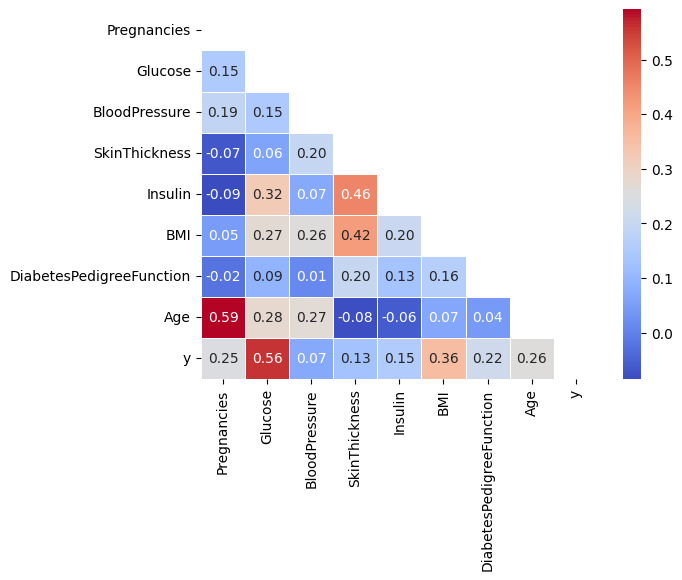

In [34]:
X_corr = X_train.copy();
X_corr['y'] = y_train;
corr = X_corr.corr();
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f');

In [35]:
X_train['Age_Pregnancies'] = X_train['Age'] * X_train['Pregnancies'];
X_test['Age_Pregnancies'] = X_test['Age'] * X_test['Pregnancies'];

X_train['Skin_BMI'] = X_train['SkinThickness'] * X_train['BMI'];
X_test['Skin_BMI'] = X_test['SkinThickness'] * X_test['BMI'];

X_train.drop(['Age', 'Pregnancies', 'SkinThickness', 'BMI'], axis = 1, inplace = True);
X_test.drop (['Age', 'Pregnancies', 'SkinThickness', 'BMI'], axis = 1, inplace = True);

vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

Glucose                     1.957542
BloodPressure               1.643795
Insulin                     3.139463
DiabetesPedigreeFunction    1.272038
Age_Pregnancies             1.532765
Skin_BMI                    2.958884
dtype: float64

## Paso 3 - Escalado de Variables:

En esta ocasión, al ir a analizar un algoritmo basado en Decision Trees, **no es necesario realizar ningún escalado** al no ser sensibles a estas variaciones.

## Paso 4 - Estudio del modelo de tipo Decision Tree:

Una vez ya se ha **preparado el conjunto de datos** a través del análisis exploratorio de datos y se ha comprendido su distribución y características, se va a llevar a cabo un **estudio de árboles de decisión**, ajustando distintos **hiperparámetros** para optimizar su rendimiento. 

Los **árboles de decisión** son modelos de aprendizaje supervisado cuya estructura jerárquica permite **tomar decisiones sobre los datos** dividiéndolos en subconjuntos más simples. Esta **división varía dependiendo del tipo de algoritmo** de machine learning que se esté utilizado, regresión o clasificación. En este caso, se ha de **predecir si un paciente es o no diabético** (1 o 0), por lo tanto se utlizará un **árbol de decisión de tipo clasificador**. 

La **principal ventaja** de estos modelos recae en su **fácil interpretación**, a la par que la capacidad de manejar datos **sin necesidad de escalado**. Sin embargo, **si no se regulan** adecuadamente mediante los hiperparámetros, pueden caer un **sobreajuste**. 

Para poder definir estos hiperparámetros de forma correcta, es necesario conocer su utilidad:

- `max_depth` : Controla la profundidad máxima del árbol, es decir, el número de iteraciones que ha de realizar sobre el conjunto de datos

- `criterion` : Define la métrica para evaluar la calidad de las divisiones. En este caso, al tratarse de un clasificador, las divisiones dependerán de la entropía, por lo que aquí se puede elegir qué tipo de estadística se desea para medir este parámetro. 

- `min_samples_split` : Número mínimo de muestras necesarias para dividir un nodo

- `min_samples_leaf` : Número mínimo de muestras que debe contener un nodo hoja

- `max_features`: Número máximo de características consideradas en cada división



Teniendo esto en cuenta, para poder evaluar la importancia de una correcta selección de los hiperparámetros, se van a declarar dos tipos de árboles de decisión:

- **Árbol de Decisión Sencillo:** Se realiza una predicción en base a un **entrenamiento poco exhaustivo**. Esto puede llevar a una **tasa de error alta** tanto en el conjunto de **entrenamiento** como en el de **test**. 

- **Árbol de Decisión Complejo:** Se realiza una predicción en base a un **entrenamiento demasiado exhaustivo**. Esto puede llevar a un **sobreajuste** del modelo, es decir, a un **aprendizaje a medida** para el conjunto de **entrenamiento** (con una tasa de error muy baja) pero poco generalizado, con una **tasa de error alta** para el conjunto de **test**. 

De esta forma, como ya se tiene el conjunto de datos separado en train y test, se puede prodecer a **instanciar y entrenar dos objetos** de la clase `DecisionTreeClassifier` para poder comenzar a modelar:

In [36]:
# # # Decision Tree Simple # # #
simple_tree = DecisionTreeClassifier(max_depth = 3, max_features = X_train.shape[1]//2, min_samples_leaf = 10, random_state = 42).fit(X_train, y_train);

# # # Decision Tree Complejo # # #
complex_tree = DecisionTreeClassifier(max_depth = 100, min_samples_leaf = 1, random_state = 42).fit(X_train, y_train);

La elección de hiperparámetros para cada uno de los casos ha sido la siguiente:

- **Árbol de Decisión Simple:** Se ha optado por una **profundidad muy baja**, de solo 3 nodos y un número mínimo de muestras por nodo hoja de 10. Sin embargo, la elección que más puede llegar a influir en la capacidad predictiva del modelo es `max_features` al haber decidido que únicamente se tengan en cuenta la **mitad de las características en cada decisión**. 

Por el contrario...

- **Árbol de Decisión Complejo:** Se ha optado por tener en cuenta **todas las características en cada decisión**, siendo este el valor por defecto y no teniendo que especificarlo. Además, se ha elegido una **profundidad de árbol mucho mayor** y, un número **mínimo de muestras por nodo hoja de 1**. Esto implica que el modelo puede ser demasiado complejo, con muchas hojas individuales que reflejen **variaciones específicas del conjunto de entrenamiento** y no sean generalizables a otros datos. 

A continuación, se va a realizar la **predicción** tanto en los valores de entrenamiento como en los de test, utilizando el método `.predict()`:

In [37]:
# # # Predicción - Decision Tree Simple # # #
train_hat_simple = simple_tree.predict(X_train);
test_hat_simple = simple_tree.predict(X_test);

# # # Predicción - Decision Tree Complejo # # #
train_hat_complex = complex_tree.predict(X_train);
test_hat_complex = complex_tree.predict(X_test);

Finalmente, lo interesante es **analizar las métricas** que aportan cada uno de estos modelos para **evaluar su capacidad predictiva**. Para ello, se va a declarar una función, dados las variables objetivo reales y las predichas (para el *train* y *test* set), pueda obtener cada uno de estos parámetros y los muestre por pantalla:

In [38]:
# Definición de la función para obtener las métricas de los modelos dadas las variables objetivo reales y las predichas
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df